In [4]:
file_path = 'hardest.mp3'
downsampling_rate = 32
show_chroma = 0
show_downsample = 0
show_raw_ssm = 0

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import librosa

def convolve(image, kernel):
    image, kernel = np.asarray(image), np.asarray(kernel, float)
    if len(image.shape) == 1: image = image[np.newaxis,:]
    if len(image.shape) == 1: kernel = kernel[np.newaxis,:]

    if image.size < kernel.size:
        image, kernel = kernel, image

    g = np.zeros(np.array(image.shape) + np.array(kernel.shape) - 1)
    if kernel.ndim == 2:
        H, W = image.shape
        for (r, c) in np.transpose(np.nonzero(kernel)):
            g[r:r+H, c:c+W] += image * kernel[r,c]

    if kernel.ndim == 3:
        D, H, W = image.shape
        for (D, H, W) in np.transpose(np.nonzero(kernel)):
            g[d:d+D, r:r+H, c:c+W] += image * kernel[d,r,c]

    additional_size = kernel.shape[0]//2, kernel.shape[1]//2
    image_size = g.shape
    return g[additional_size[0]:image_size[0]-additional_size[0],
             additional_size[1]:image_size[1]-additional_size[1]]
        

y, sr = librosa.load(file_path)

# Here feature vector is created
# Uncomment for Chromagram
feature = librosa.feature.chroma_cens(y=y, sr=sr)

# Uncomment for MFCC
#feature = librosa.feature.mfcc(y=y, sr=sr)

# Uncomment for Tempogram
#oenv = librosa.onset.onset_strength(y=y, sr=sr)
#feature = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)

if show_chroma:
    librosa.display.specshow(feature, sr=sr, x_axis='time')
    plt.title('Feature sequence')
    plt.colorbar()
    plt.show()

# Here chromagram is downsampled
N = feature.shape[1]/downsampling_rate
F = feature.shape[0]
ds = np.ndarray((F,N))
for i in np.arange(N):
    ds[:,i] = np.mean(feature[:,downsampling_rate*i:downsampling_rate*(i+1)],axis=1)

if show_downsample:
    librosa.display.specshow(ds, sr=sr, x_axis='time')
    plt.title('Feature sequence')
    plt.colorbar()
    plt.show()
    
# Here raw ssm is created
out = np.ndarray((N,N))
for i in np.arange(N):
    a = ds[:,i]
    for j in np.arange(N):
        b = ds[:,j]
        out[i,j] = np.dot(a,b)#/(np.linalg.norm(a)*np.linalg.norm(b))

if show_raw_ssm:
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(out, x_axis='time', y_axis='time', sr=sr/downsampling_rate, n_xticks=12)
    plt.title('ssm')
    plt.colorbar()
    plt.show()

/home/fabio/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:482: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array(a, dtype, copy=False, order=order)


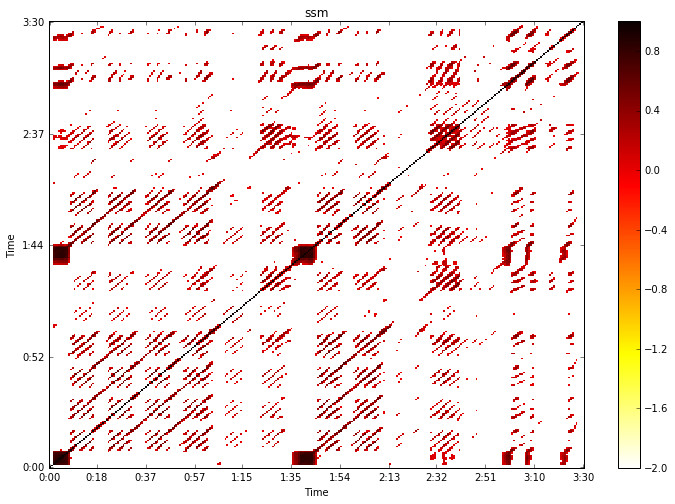

In [5]:
# Convolution raw ssm enhancing diagonal path
kernel_size = 8
kernel = np.identity(6)
blur_out = convolve(out, kernel/kernel_size)

# Normalizing value between 0 and 1 and applying threshold so some values get penalties
negative = (blur_out<0.69)*2
positive = blur_out*(blur_out>0.69)-(blur_out>0.69)*0.69
positive = positive/positive.max()
ssm = positive-negative

# Enforce main diagonal to value 1
for x in np.arange(ssm.shape[0]):
    ssm[x,x] = 1

plt.figure(figsize=(12, 8))
librosa.display.specshow(ssm, x_axis='time', y_axis='time', sr=sr/downsampling_rate, n_xticks=12)
plt.title('ssm')
plt.colorbar()
plt.set_cmap('hot_r')
plt.show()

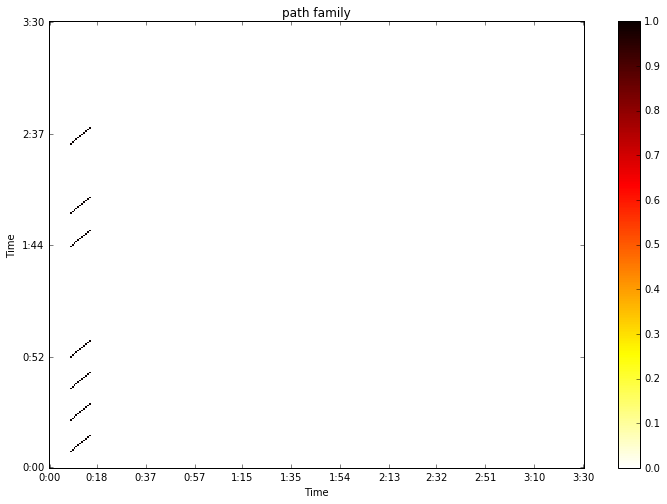

In [46]:
def segmentScore(segment,ssm):
    scores = np.ndarray((ssm.shape[0]-segment[1]+segment[0]))
    paths = []
    p_star = []
    for i in np.arange(segment[1]-segment[0],ssm.shape[0]):
        path = pathScore(segment[0],(segment[1]-1,i),ssm)
        scores[i-segment[1]+segment[0]] = path[0]
        paths.append(path)
    scores.sort()
    paths.sort()
    for i in np.where(scores>0)[0]:
        path = (paths[i][1][0][1], paths[i][1][-1][1], scores[i])
        conflict = []
        for j in np.arange(len(p_star)):
            if abs(p_star[j][0]-path[0])<15:
                conflict.append(j)
        if len(conflict)==0:
            p_star.append(path)
        elif len(conflict)==1:
            p_star[conflict[0]] = path
        else:
            #not good
            for i in np.arange(len(conflict)):
                p_star.remove(p_star[conflict[i]])
            p_star.append(path)
    return p_star

def pathFamilyScore(s,T,ssm):
    familyScore = 0
    pathFamily = []
    for t in T:
        score, path = pathScore(s,t,ssm)
        familyScore = familyScore + score
        pathFamily.append(path)
    return familyScore, pathFamily

def pathScore(s,t,ssm):
    score = ssm[t]
    pathcells = [t]
    while t[0]>s:
        t = (t[0]-1,t[1]-1)
        score = score + ssm[t]
        if t[1]<0:
            score = -np.inf
            break
        pathcells.append(t)
    return score, pathcells
    
def print_p_star(segment, p_star, ssm):
    s = segment[0]
    paths_matrix = np.zeros(ssm.shape)
    for i in np.arange(len(p_star)):
        t = (p_star[i][0],segment[1])
        while t[1]>s:
            t = (t[0]-1,t[1]-1)
            paths_matrix[t] = 1
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(paths_matrix, x_axis='time', y_axis='time', sr=sr/downsampling_rate, n_xticks=12)
    plt.title('path family')
    plt.colorbar()
    plt.set_cmap('hot_r')
    plt.show()

segment = (11,22)
p_star = segmentScore(segment,ssm)
print_p_star(segment, p_star, ssm)

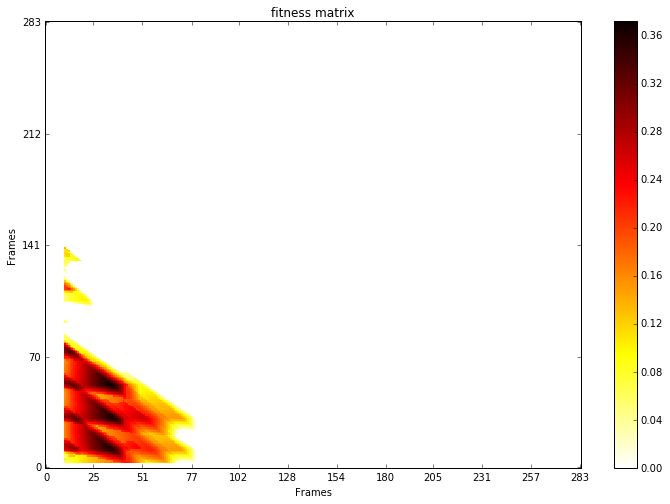

In [16]:
def fitnessMatrix(ssm):
    min_seg = 3
    max_seg = 150
    min_size = 10
    max_size = max_seg-min_seg
    fitness_matrix = np.zeros(ssm.shape)#(max_seg-min_seg,max_seg-min_seg))
    for i in np.arange(min_seg,max_seg):
        for j in np.arange(i+min_size,min(i+max_size,max_seg)):
            segment = (i,j)
            fitness_matrix[i,j-i] = fitness(segment, ssm)
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(fitness_matrix, x_axis='frames', y_axis='frames', sr=sr/downsampling_rate, n_xticks=12)
    plt.title('fitness matrix')
    plt.colorbar()
    plt.set_cmap('hot_r')
    plt.show()
    
def fitness(segment, ssm):
    score = 0
    coverage = 0
    segment_length = (segment[1] - segment[0])
    p_star = segmentScore(segment,ssm)
    for i in np.arange(len(p_star)):
        score = score + p_star[i][2]
        coverage = coverage + p_star[i][0]-p_star[i][1]+1.0
    normalized_score = (score - segment_length) / ((len(p_star))*(segment_length))
    normalized_coverage = (coverage - segment_length) / ssm.shape[0]
    if normalized_score==0 or normalized_coverage==0:
        return 0
    return 2*normalized_score*normalized_coverage/(normalized_score+normalized_coverage)

def convert_to_time(sample):
    return sample*(sr/downsampling_rate)/60/1000.0


fm = fitnessMatrix(ssm)